# Pairs trading model based on stochastic optimal control

The model computes the optimal asset allocation $h_{t}^{*}$ by maximizing terminal payoff of the strategy:

$h_{t}^{*} := \underset{h(t)}{sup} \ \mathbb{E}\left[ \frac{1}{\gamma}V(T)^{\gamma}\right]$

subject to:

$dX_{t} = \kappa (\theta - X_t)dt + \eta dW_{t}^{x}$

and

$dV_{t} = \left[h_t \left(\kappa (\theta - X_t)+ \frac{1}{2}\eta^{2}+\rho \sigma \eta \right) + r \right]V_t dt + h_tV_t \eta dW_{t}^{x} $

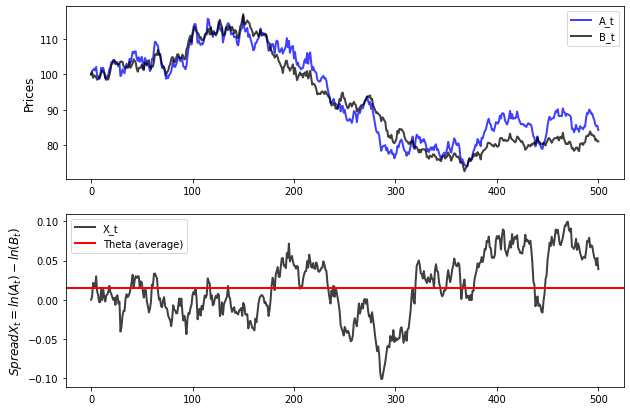

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from src.simulation.simulate_cointegrated_assets import simulate_ou_spread

B_0     = 100   # Initial price of asset B at time t=0
sigma_B = 0.15  # Volatility of asset B
mu      = 0.05  # Drift of asset B

X_0     = 0.0   # Value of logarithmic spread X_t at time t=0
kappa   = 5.5   # Mean reversion speed of logarithmic spread X_t
theta   = 0.0   # Long-run mean of the logarithmic spread X_t = ln(A)-ln(B)
eta     = 0.15  # standard deviation of X_t

N_sim   = 1
N_steps = 500
T       = 2.0
dt      = T / N_steps

A, B, X = simulate_ou_spread(N_sim, N_steps, B_0, X_0, kappa, theta, eta, mu, sigma_B, dt)



kws_A = {'label':'A_t', 'color':'blue' , 'alpha':0.75, 'lw': 2}
kws_B = {'label':'B_t', 'color':'black', 'alpha':0.75, 'lw': 2}
kws_X = {'label':'X_t', 'color':'black', 'alpha':0.75, 'lw': 2}

fig,ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(A[:,0], **kws_A)
ax[0].plot(B[:,0], **kws_B)
ax[0].set_ylabel('Prices', fontsize=12)
ax[0].legend()

ax[1].plot(X[:,0], **kws_X)
ax[1].axhline(y=np.mean(X[:, 0]), color='red', lw=2, label='Theta (average)')
ax[1].set_ylabel(r'$Spread X_t = ln(A_t)-ln(B_t)$', fontsize=12)
ax[1].legend()

plt.show()

## Parameter estimation

The strategy is dependent on the parameters $(\kappa, \theta, \eta, \rho )$ which describe the behavior of the spread:

$dX_{t} = \kappa (\theta - X_t)dt + \eta dW_{t}^{x}$


These parameters may be estimated using OLS.


In [2]:
from src.optimal_controls.ou_params import OrnsteinUhlenbeckProcessParameters
from src.optimal_controls.ou_spread_model_parameters import OUSpreadModelStrategyParameters

# Estimate spread parameters
model_params = OrnsteinUhlenbeckProcessParameters.ols_parameter_estimation(A, B, dt)

print('Estimated theta:', model_params.theta)
print('Estimated eta:', model_params.eta)
print('Estimated kappa:', model_params.kappa)
print('True theta:', theta)
print('True eta:', eta)
print('True kappa:', kappa)

Estimated theta: 0.018163522072947965
Estimated eta: 0.15061873624556274
Estimated kappa: 7.336065457786146
True theta: 0.0
True eta: 0.15
True kappa: 5.5


We notice that our estimates are 'fairly' accurate.

## Optimal control:

We solve the optimal allocation over $(t , X_t)$ grid in order to see how the model allocates capital on asset $A$ (allocation in asset $B$ is negative of the optimal allocation in asset $A$).

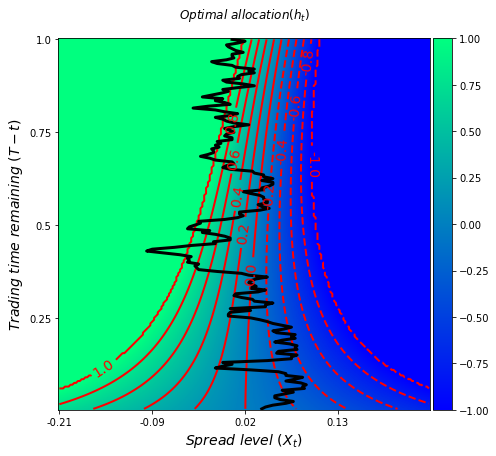

In [3]:
from utils.plot_utils import plot_optimal_solution

# Create trading model parameters
nominal  = 1000000
symbol_A = 'A'
symbol_B = 'B'
horizon  = 1.0
risk_tol = -float(100)
max_leverage = 1

strat_params = OUSpreadModelStrategyParameters(nominal, symbol_A, symbol_B, horizon, risk_tol, max_leverage)


plot_optimal_solution(X, model_params, strat_params, 200)

### Effect of the spread level $X_t$
From the heatmap above we notice that when $X_t<0$ the optimal allocation $h_{t}^{*} > 0$. In other words, when the logarithmic price spread is negative the model suggest a long position in asset $A$. This makes sense since the spread is defined to be $X_t := ln(A_t) - ln(B_t)$ then $X_t < 0$ means that at time $t$ asset $A$ is under prices relative to asset $B$.  

### Effect of trading time $t$
We notice that as the remaining trading time $T-t \to 0$ the optimal allocation tends to become more conservative. In other words, when the algorithm is running out of time the positions tend towards zero automatically. 

## Simulation of the strategy:


In [ ]:
from src.simulation.simulate_pairs_trading import simulate_strategy

print(model_params.rho)

# OU process parameters
n_sim   = 20
n_steps = 500
b_0     = 100
mu_b    = 0.05  # drift of the asset b
    
x_0 = 0.0
kappa = 5.5     # spread mean-reversion speed
theta = 0.0     # average spread level
eta = 0.05      # spread (normal) volatility
sigma_b = 0.20  # asset b annual volatility
rho = 0.0       # correlation dW_x*dW_b = rho*dt, TODO: implement in simulation, curr. not supported.

model_params = OrnsteinUhlenbeckProcessParameters(kappa, theta, eta, sigma_b, rho, mu_b, x_0, b_0)
    
a_prices, b_prices, portfolios = simulate_strategy(model_params, strat_params, 250, 10)

### Plotting

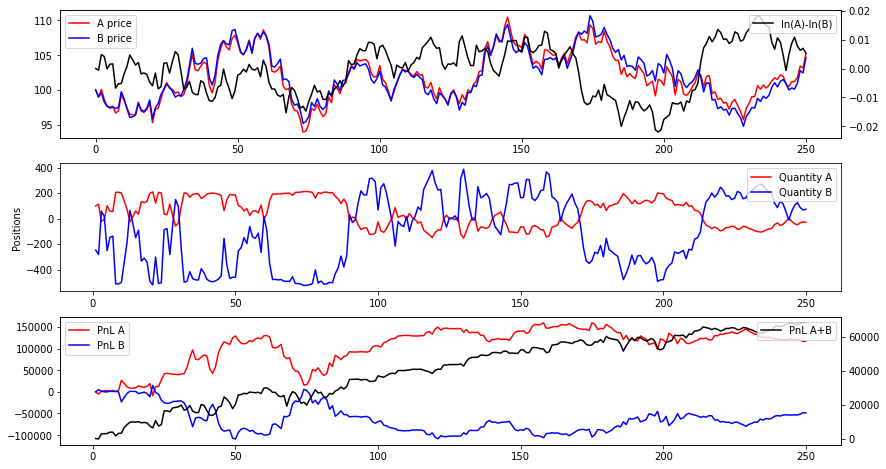

In [15]:

position_in_a = portfolios[0].get_position('A')
position_in_b = portfolios[0].get_position('B')

report_a = position_in_a.generate_report_frame()
report_b = position_in_b.generate_report_frame()

fig, ax = plt.subplots(3, 1, figsize=(14, 8))
    
# Plot asset prices
ax[0].plot(a_prices[0], color='red', label='A price')
ax[0].plot(b_prices[0], color='blue', label='B price')
ax[0].legend(loc=2)
    
# Plot logarithmic spread
ax02 = ax[0].twinx()
ax02.plot(np.log(a_prices[0]) - np.log(b_prices[0]), color='black', label='ln(A)-ln(B)')
ax02.legend(loc=1)

# Plot positions
ax[1].plot(report_a['NET_POSITION'], color='red', label='Quantity A')
ax[1].plot(report_b['NET_POSITION'], color='blue', label='Quantity B')
ax[1].set_ylabel('Positions')
ax[1].legend(loc=1)

    
# Plot profit and loss 
ax[2].plot(report_a['TOTAL_PNL'], color='red', label='PnL A')
ax[2].plot(report_b['TOTAL_PNL'], color='blue', label='PnL B')
ax[2].legend(loc=2)

ax22 = ax[2].twinx()
ax22.plot(report_a['TOTAL_PNL'] + report_b['TOTAL_PNL'], color='black', label='PnL A+B')
ax22.legend(loc=1)

plt.show()
